Step 1: Upload the Data and perform the initial inspection
- Target Value: 'TOT_PAID' and date column: 'ACC_MONTH'
- Feature Columns: 'EST_COST', 'NBR_CASE' = 'NBR_KEY_CASE' + 'NBR_OTHER'
due to the mathematical equation between case related fields only one of them along with the 'EST_COST' has the potential to be a valid regressor

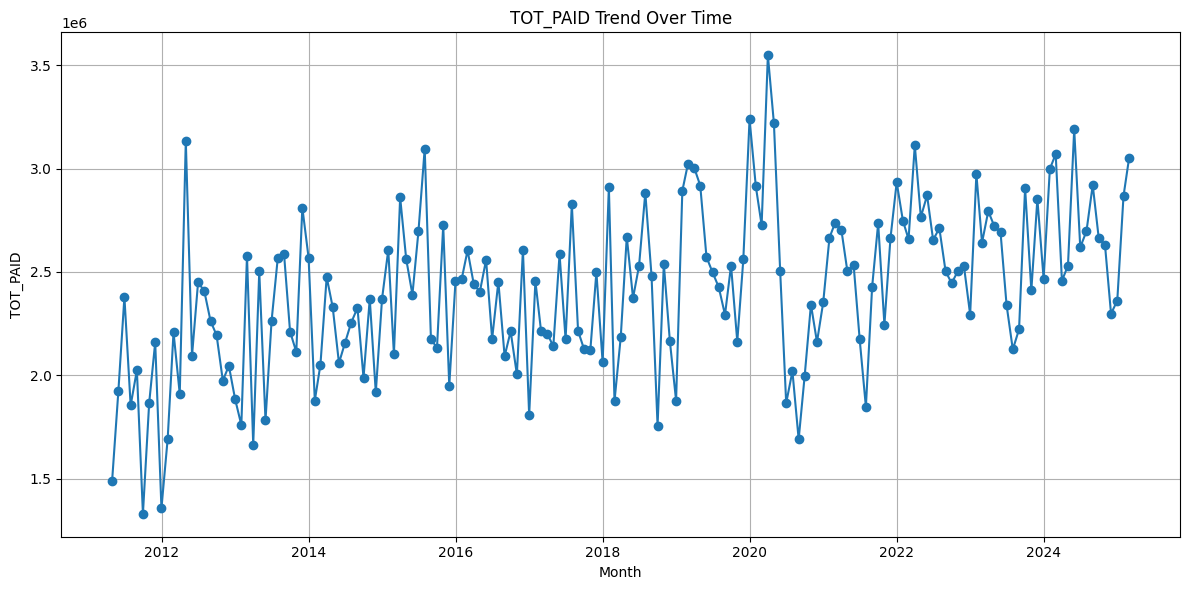

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests



# Load Dataset
data = pd.read_csv("C:\GitHub\Machine-Learning\data\Payment Data.csv")

# dataset preprocess
data['ACC_MONTH'] = pd.to_datetime(data['ACC_MONTH'])
df = data[['ACC_MONTH', 'TOT_PAID', 'EST_COST', 'NBR_CASE', 'NBR_KEY_CASE','NBR_OTHER']].dropna()
data = data.sort_values(by='ACC_MONTH')


# Plot the trend of TOT_PAID
plt.figure(figsize=(12, 6))
plt.plot(df['ACC_MONTH'], df['TOT_PAID'], marker='o', linestyle='-')
plt.title('TOT_PAID Trend Over Time')
plt.xlabel('Month')
plt.ylabel('TOT_PAID')
plt.grid(True)
plt.tight_layout()
plt.show()


Step 2: Correlation and Lag analysis, using statistical test: Garnger Casualty

Calculating the correlation between the target value and potential regressors, running a lag correlation analysis and testing the best lag’s significance by Granger Casualty Test and finalizing the potential regressors and their lag in the model 

\Pearson Correlation Coefficients:
              NBR_CASE  NBR_OTHER  NBR_KEY_CASE
NBR_CASE         1.000      0.919         0.604
NBR_OTHER        0.919      1.000         0.241
NBR_KEY_CASE     0.604      0.241         1.000

P-values of Pearson Correlation Tests:
              NBR_CASE  NBR_OTHER  NBR_KEY_CASE
NBR_CASE           0.0     0.0000        0.0000
NBR_OTHER          0.0     0.0000        0.0017
NBR_KEY_CASE       0.0     0.0017        0.0000


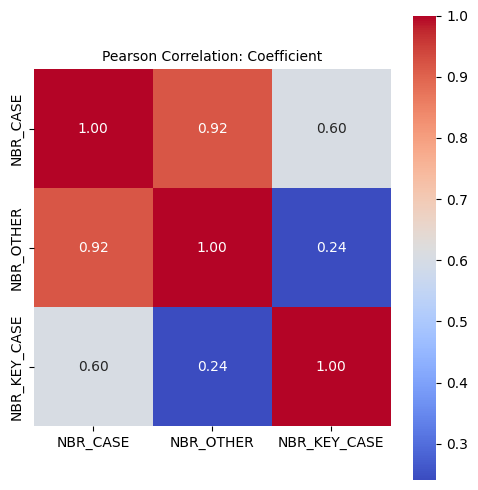

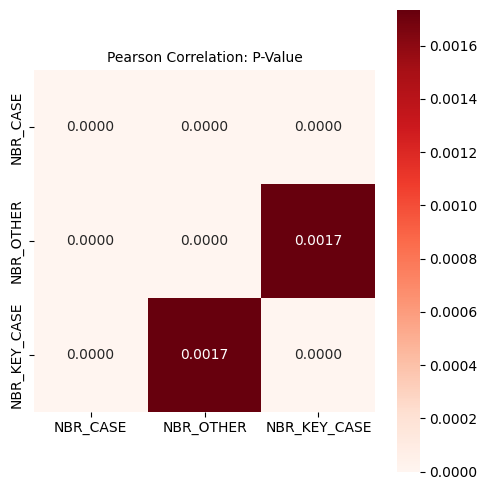

In [34]:
2.1 #Correlation Analysis
import numpy as np
from scipy.stats import pearsonr


# Select numeric features for correlation
features = ['NBR_CASE', 'NBR_OTHER', 'NBR_KEY_CASE']
df_corr = df[features].dropna()

# Initialize empty DataFrames for correlations and p-values
corr_matrix = pd.DataFrame(index=features, columns=features, dtype=float)
pval_matrix = pd.DataFrame(index=features, columns=features, dtype=float)

# Compute Pearson correlation and p-values
for col1 in features:
    for col2 in features:
        corr, pval = pearsonr(df_corr[col1], df_corr[col2])
        corr_matrix.loc[col1, col2] = corr
        pval_matrix.loc[col1, col2] = pval

# Display the correlation matrix
print("\Pearson Correlation Coefficients:")
print(corr_matrix.round(3))

# Display the p-value matrix
print("\nP-values of Pearson Correlation Tests:")
print(pval_matrix.round(4))

# Optional: Plot correlation matrix
plt.figure(figsize=(5,5))
sns.heatmap(corr_matrix.astype(float), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Pearson Correlation: Coefficient",fontsize=10)
plt.tight_layout()
plt.show()

# Optional: Plot p-values
plt.figure(figsize=(5, 5))
sns.heatmap(pval_matrix.astype(float), annot=True, fmt=".4f", cmap="Reds", square=True)
plt.title("Pearson Correlation: P-Value",fontsize=10)
plt.tight_layout()
plt.show()


# output: As we expected: NBR_CASE has significant intercorrelation with NBR_KEY_CASE(0.6) and NBR_OTHER (0.92) (NBR_CASE = NBR_KEY_CASE + NBR_OTHER)
# we can skip this stage as it does not have much to add to this analysis

Best Lag for EST_COST: 12.0 months (Correlation = 0.70)


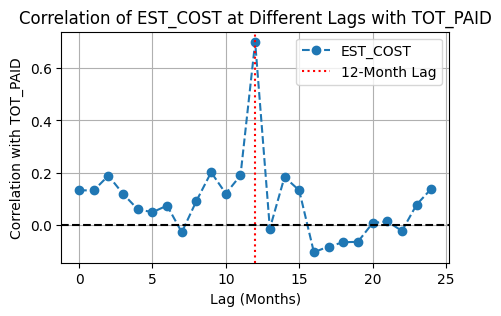

Best Lag for NBR_KEY_CASE: 12.0 months (Correlation = 0.34)


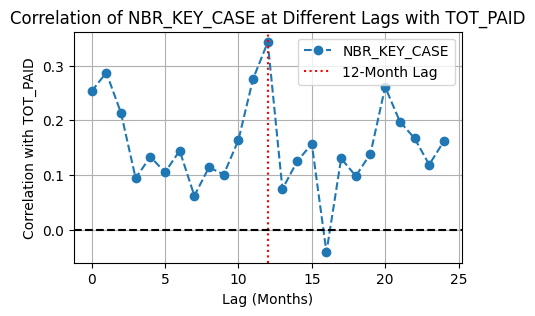

Best Lag for NBR_CASE: 12.0 months (Correlation = 0.53)


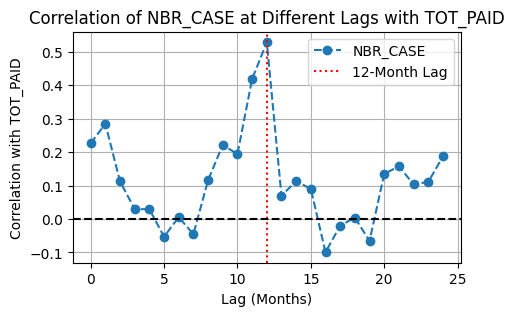

Best Lag for NBR_OTHER: 12.0 months (Correlation = 0.47)


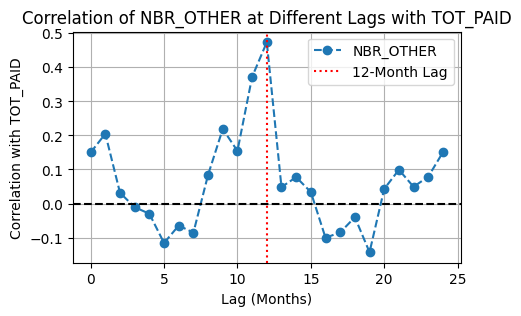


Running Granger Causality Test (Does EST_COST Granger-cause TOT_PAID?)

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4384  , p=0.2321  , df_denom=163, df_num=1
ssr based chi2 test:   chi2=1.4649  , p=0.2262  , df=1
likelihood ratio test: chi2=1.4584  , p=0.2272  , df=1
parameter F test:         F=1.4384  , p=0.2321  , df_denom=163, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3848  , p=0.0954  , df_denom=160, df_num=2
ssr based chi2 test:   chi2=4.9187  , p=0.0855  , df=2
likelihood ratio test: chi2=4.8468  , p=0.0886  , df=2
parameter F test:         F=2.3848  , p=0.0954  , df_denom=160, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2312  , p=0.3003  , df_denom=157, df_num=3
ssr based chi2 test:   chi2=3.8583  , p=0.2772  , df=3
likelihood ratio test: chi2=3.8136  , p=0.2823  , df=3
parameter F test:         F=1.2312  , p=0.3003  , df_denom=157, df_num=3

Granger Causality
num

In [ ]:
# 2.2 LAG Analysis:
import warnings
# Function to test lag correlation analysis
def test_lag_correlation(target, regressor, max_lag=24):
    correlations = {}
    
    for lag in range(0, max_lag + 1):
        with warnings.catch_warnings():
             warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)
        df[f'{regressor}_LAG_{lag}'] = df[regressor].shift(lag)
        correlations[lag] = df[[target, f'{regressor}_LAG_{lag}']].corr().iloc[0, 1]
    
    correlation_df = pd.DataFrame(list(correlations.items()), columns=['Lag (Months)', 'Correlation'])
    best_lag = correlation_df.iloc[correlation_df['Correlation'].abs().idxmax()]
    
    print(f"Best Lag for {regressor}: {best_lag['Lag (Months)']} months (Correlation = {best_lag['Correlation']:.2f})")
    
    plt.figure(figsize=(5, 3))
    plt.plot(correlation_df['Lag (Months)'], correlation_df['Correlation'], marker='o', linestyle='dashed', label=regressor)
    plt.axvline(x=12, color='red', linestyle='dotted', label="12-Month Lag")
    plt.axhline(y=0, color='black', linestyle='dashed')
    plt.xlabel("Lag (Months)")
    plt.ylabel("Correlation with TOT_PAID")
    plt.title(f"Correlation of {regressor} at Different Lags with TOT_PAID")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return best_lag


# Test lag correlation for EST_COST, NBR_KEY_CASE, NBR_OTHER and NBR_CASE
best_est_cost_lag = test_lag_correlation('TOT_PAID', 'EST_COST')
best_key_case_lag = test_lag_correlation('TOT_PAID', 'NBR_KEY_CASE')
best_case_lag = test_lag_correlation('TOT_PAID', 'NBR_CASE')
best_other_case_lag = test_lag_correlation('TOT_PAID', 'NBR_OTHER')

# Run Granger Causality Test for each regressor
print("\nRunning Granger Causality Test (Does EST_COST Granger-cause TOT_PAID?)")
granger_budget = grangercausalitytests(df[['TOT_PAID', 'EST_COST']].dropna(), best_est_cost_lag['Lag (Months)'])

print("\nRunning Granger Causality Test (Does NBR_KEY_CASE Granger-cause TOT_PAID?)")
granger_murder = grangercausalitytests(df[['TOT_PAID', 'NBR_KEY_CASE']].dropna(), best_key_case_lag['Lag (Months)'])

print("\nRunning Granger Causality Test (Does NBR_CASE Granger-cause TOT_PAID?)")
granger_case = grangercausalitytests(df[['TOT_PAID', 'NBR_CASE']].dropna(), best_case_lag['Lag (Months)'])

print("\nRunning Granger Causality Test (Does NBR_OTHER Granger-cause TOT_PAID?)")
granger_case = grangercausalitytests(df[['TOT_PAID', 'NBR_OTHER']].dropna(), best_other_case_lag['Lag (Months)'])

#Output: there is a significant correlation btweent the target value and features at lag 12 which is statistically confirmed by Granger Cause test.
# It means that features are Granger Causing TOT_PAID at lag 12 
# What does it mean? The value of Nbr of Cases and also Est Cost after 12 months (lag 12) shows a siginificant impact (correlation) on Total Expenditure



 Explained Variance Ratio per Principal Component:
PC1: 0.6934
PC2: 0.1955
PC3: 0.1111
PC4: 0.0000


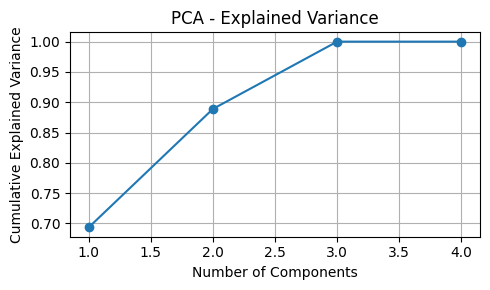


 Feature Importance Based on PCA Loadings:
              Average Importance
NBR_OTHER               0.489133
NBR_CASE                0.430779
NBR_KEY_CASE            0.427243
EST_COST                0.352642


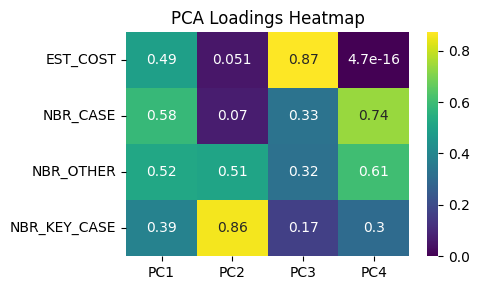

In [ ]:
#2.3 PCA analysis

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Standardize the features
features = ['EST_COST', 'NBR_CASE', 'NBR_OTHER', 'NBR_KEY_CASE']
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_var = pca.explained_variance_ratio_
print("\n Explained Variance Ratio per Principal Component:")
for i, var in enumerate(explained_var):
    print(f"PC{i+1}: {var:.4f}")

# Plot cumulative variance
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(explained_var)+1), explained_var.cumsum(), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature importance per component (absolute values of loadings)
loadings = pd.DataFrame(
    abs(pca.components_.T),
    columns=[f'PC{i+1}' for i in range(len(features))],
    index=features
)

# Optional: Average importance across all components
loadings['Average Importance'] = loadings.mean(axis=1)
loadings_sorted = loadings.sort_values(by='Average Importance', ascending=False)

print("\n Feature Importance Based on PCA Loadings:")
print(loadings_sorted[['Average Importance']])

# Optional: Heatmap of PCA loadings
plt.figure(figsize=(5, 3))
sns.heatmap(loadings.drop(columns='Average Importance'), annot=True, cmap='viridis')
plt.title("PCA Loadings Heatmap")
plt.tight_layout()
plt.show()

#output: the most important feature factor in this analysis is: NBR_OTHER and the 2nd (if applicable)would be EST_COST.
# because of the math equation between NBR_CASE, NBR_KEY_OTHER and NBR_OTHER

#Conclustion: at the end of step 2 we can conclude that: Target value is 'TOT_PAID', Features at lag 12: 'NBR_OTHER' and 'EST_COST' 
# Therefore, we can start the Model Fitting at the next step

Step 3: Model Fitting and measuring model's accuracy by RMSE, MAE, MAPE

Testing various time series methods and measuring the effect of seasonality and regressors in the model. Selecting the best method with the most useful regressors based on their accuracy measured by RMSE, MAE and MAPE. 

Step 4: Forecasting 18 months to the future

Forecasting regressors for 18 months future to be used for forecasting 18 months future total expenditures 

Step 5: Analysing the outupt - Plotting the trends and forecasts